## Climate indicator comparisons

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr
from scipy.stats import t as student_t
from statsmodels.tsa.stattools import acf
import matplotlib.lines as mlines

IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [2]:
obs = pd.read_csv(IOPATH)
obs

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                       time  \
0                   0             0           0  1933-07-25 00:00:00+00:00   
1                   1             1           1  1933-07-25 00:00:00+00:00   
2                   2             2           2  1933-07-25 00:00:00+00:00   
3                   3             3           3  1933-07-25 00:00:00+00:00   
4                   4             4           4  1933-07-25 00:00:00+00:00   
...               ...           ...         ...                        ...   
1722329       1722329       1722329     1805040  2024-11-18 00:00:00+00:00   
1722330       1722330       1722330     1805041  2024-11-18 00:00:00+00:00   
1722331       1722331       1722331     1805042  2024-11-18 00:00:00+00:00   
1722332       1722332       1722332     1805043  2024-11-18 00:00:00+00:00   
1722333       1722333       1722333     1805044  2024-11-18 00:00:00+00:00   

         longitude (degrees_east)  latitude (degrees_north)  depth (m)  \
0                         -126.76                     49.34        1.0   
1                         -126.76                     49.34        2.0   
2                         -126.76                     49.34        4.0   
3                         -126.76                     49.34        6.0   
4                         -126.76                     49.34       10.0   
...                           ...                       ...        ...   
1722329                   -124.95                     44.38        0.0   
1722330                   -124.94                     44.36        0.0   
1722331                   -124.57                     46.99        0.0   
1722332                   -124.56                     46.99        0.0   
1722333                   -124.31                     44.64        0.0   

         pressure (dbar)  temperature (degC)  salinity (g kg-1)  ...  \
0               1.008587                 NaN          32.070847  ...   
1               2.017180                 NaN          32.090943  ...   
2               4.034378                 NaN          32.090906  ...   
3               6.051598                 NaN          32.090870  ...   
4              10.086095                 NaN          32.181305  ...   
...                  ...                 ...                ...  ...   
1722329         0.000000           12.713836          32.386146  ...   
1722330         0.000000           12.712860          32.386131  ...   
1722331         0.000000           10.586080          32.728763  ...   
1722332         0.000000           12.215222          32.245641  ...   
1722333         0.000000           11.112893          32.193448  ...   

         Ni (nmol kg-1)  Zn (nmol kg-1)      source  current  location  \
0                   NaN             NaN  ios bottle    shelf     shelf   
1                   NaN             NaN  ios bottle    shelf     shelf   
2                   NaN             NaN  ios bottle    shelf     shelf   
3                   NaN             NaN  ios bottle    shelf     shelf   
4                   NaN             NaN  ios bottle    shelf     shelf   
...                 ...             ...         ...      ...       ...   
1722329             NaN             NaN         ooi      NaN     slope   
1722330             NaN             NaN         ooi      NaN     slope   
1722331             NaN             NaN         ooi    shelf     shelf   
1722332             NaN             NaN         ooi    shelf     shelf   
1722333             NaN             NaN         ooi    shelf     shelf   

         [TA-DIC] (uM)  year  month      NSdist  EWdist  
0                  NaN  1933      7 -158.177943    -0.0  
1                  NaN  1933      7 -158.177943    -0.0  
2                  NaN  1933      7 -158.177943    -0.0  
3                  NaN  1933      7 -158.177943    -0.0  
4                  NaN  1933      7 -158.177943    -0.0  
...                ...   ...    ...         ...     ...  
1722329            NaN 

In [3]:
pd.unique(obs['current'])

array(['shelf', nan, 'CUC', 'CC'], dtype=object)

In [4]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

In [5]:
# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

/tmp/ipykernel_3106022/497193821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cuc['dist'] = obs_cuc.NSdist
/tmp/ipykernel_3106022/497193821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_shelf['dist'] = obs_shelf.NSdist
/tmp/ipykernel_3106022/497193821.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### Where I got climate indicators from:

Originally from my research with Rich which can be found in /ocean/ghoeven/Atlas/Climatology2024

enso.csv 
https://psl.noaa.gov/enso/mei/

npgo.csv 
http://www.o3d.org/npgo/

pdo.csv
https://www.ncei.noaa.gov/access/monitoring/pdo/

bifurcation_index.csv
https://github.com/michaelmalick/bifurcation-index?utm_source=chatgpt.com

In [6]:
def add_time(df, year_col="year", month_col="month"):
    df = df.copy()
    df["day"] = 1
    df["time"] = pd.to_datetime(df[[year_col, month_col, "day"]])
    return df

def add_decimal_year(df, year_col="year", time_col="time"):
    df = df.copy()
    start_of_year = pd.to_datetime(df[year_col].astype(str) + "-01-01")
    end_of_year   = pd.to_datetime((df[year_col] + 1).astype(str) + "-01-01")
    df["decimal_yr"] = df[year_col] + (df[time_col] - start_of_year) / (end_of_year - start_of_year)
    return df

def add_running_mean_12m(value,time, *, center=True, min_periods=12):
    """
    12-month running mean on a monthly series.
    center=True -> centered window (recommended if you want a pure low-pass feel)
    min_periods=12 -> require a full 12 months for a value
    """
    s = pd.Series(np.array(value), index=pd.to_datetime(time)).sort_index()

    # original validity mask
    valid = ~s.isna()

    # fill gaps
    s_filled = s.asfreq("MS").interpolate("time", limit_direction="both")

    y = s_filled.rolling(window=12, center=True, min_periods=12).mean().values

    # restore original NaN mask (prevents n increasing)
    y[~valid] = np.nan

    return y


# -------------------------
# ENSO (wide -> long -> monthly rm12)
# -------------------------
enso = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/enso1979.csv",
    names=["year"] + [str(x + 1) for x in range(12)]
)

enso = enso.melt(id_vars="year", var_name="month", value_name="index")
enso["month"] = enso["month"].astype(int)
enso = enso.sort_values(["year", "month"]).reset_index(drop=True)

enso = add_time(enso)
enso = add_decimal_year(enso)
enso["index_rm12"] = add_running_mean_12m(enso['index'],enso['time'])


# -------------------------
# NPGO (already long -> monthly rm12)
# -------------------------
npgo = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/npgo1950.csv",
    names=["year", "month", "index"]
)

npgo["month"] = npgo["month"].astype(int)
npgo = npgo.sort_values(["year", "month"]).reset_index(drop=True)

npgo = add_time(npgo)
npgo = add_decimal_year(npgo)
npgo["index_rm12"] = add_running_mean_12m(npgo['index'],npgo['time'])


# -------------------------
# PDO (wide -> long -> monthly rm12)
# -------------------------
pdo = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/pdo1854.csv",
    names=["year"] + [str(x + 1) for x in range(12)]
)

pdo = pdo.melt(id_vars="year", var_name="month", value_name="index")
pdo["month"] = pdo["month"].astype(int)
pdo = pdo.sort_values(["year", "month"]).reset_index(drop=True)

pdo = add_time(pdo)
pdo = add_decimal_year(pdo)
pdo["index_rm12"] = add_running_mean_12m(pdo['index'],pdo['time'])

# ------
# BI
# ------
df = pd.read_csv(
    "/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/bifurcation_index.csv",
    header=11,names=["year","index"],
)
bi = pd.DataFrame()
bi['year'] = np.repeat(df.year,12)
bi['month'] = np.tile(np.arange(1,13),len(df.year))
bi['day'] = 1
bi['index_rm12'] = np.repeat(df['index'],12)
bi['time'] = pd.to_datetime(bi[['year', 'month', 'day']])

start_of_year = pd.to_datetime(bi['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((bi['year'] + 1).astype(str) + "-01-01")
bi['decimal_yr'] = bi['year'] + (
    (bi['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)


## Functions

In [7]:
# ---------- helpers ----------
def _ensure_numeric(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def decimal_year_monthstart_to_datetime(t_month):
    # get t_month into a date format that the filtering can handle
    t = np.asarray(t_month, float)
    years = np.floor(t).astype(int)
    months = (np.round((t - years) * 12).astype(int) + 1).clip(1, 12)
    return pd.to_datetime(
        {"year": years, "month": months, "day": np.ones_like(years)}
    )

# ---------- statistics ----------
def _calc_stats(mean_anom, df2, t_month, lag_months=0):
    # 1. Make both series pandas Series with decimal-year index
    df2_series = pd.Series(df2['index_rm12'].values, index=df2['decimal_yr'])
    # shift anom series forward by lag months while you do so
    anom_series = pd.Series(mean_anom, index=t_month)
    anom_shifted_index = anom_series.index + (lag_months / 12.0)
    anom_series = pd.Series(anom_series.values, index=anom_shifted_index)

    # 2. Reindex to match the anomaly time base
    df2_aligned = df2_series.reindex(anom_series.index, method='nearest', tolerance=1/52)
    # tolerance=1/52 ~ ±1 weeks in decimal-year units

    # 3. Drop NaNs (if df2 doesn't cover full range)
    mask = ~df2_aligned.isna() & ~anom_series.isna()
    df2_matched = df2_aligned[mask].values
    anom_matched = anom_series[mask].values

    stats = {}
    stats['n'] = int(mask.sum())
    if stats['n'] > 2:
        stats['r'] = pearsonr(anom_matched,df2_matched).statistic
        stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
    else: 
        stats['r'] = np.nan
        stats['pvalue'] = np.nan
    
    return stats

def _find_best_lag(mean_anom, t_month, df2, max_lag_months=6):
    """
    Scan forward lags k = 0..max_lag_months (months) and return the lag with max |r|.

    Returns
    -------
    best : dict
        {'best_lag_months','r','pvalue','n','r_by_lag','p_by_lag'}
    """
    r_by_lag = []
    p_by_lag = []
    n_by_lag = []

    for k in range(int(max_lag_months) + 1):
        stats = _calc_stats(mean_anom, df2, t_month, lag_months=k)
        r_by_lag.append(stats['r'])
        p_by_lag.append(stats['pvalue'])
        n_by_lag.append(stats['n'])
    r_arr = np.asarray(r_by_lag, float)

    if np.all(np.isnan(r_arr)): # if there is no correlation (no data) then just give this message:
        return {'best_lag_months': np.nan, 'r': np.nan, 'pvalue': np.nan, 'n': 0}

    # otherwise,choose by maximum absolute correlation (r_arr)
    kbest = int(np.nanargmax(np.abs(r_arr)))
    return {'best_lag_months': kbest, 'r': r_arr[kbest], 'pvalue': p_by_lag[kbest], 'n': n_by_lag[kbest]}

def plot_panel(ax, mean_anom, df2, t_month, max_lag_months=6,colour='k',xloc=0,yloc=0.82):
    best = _find_best_lag(mean_anom, t_month, df2, max_lag_months=max_lag_months)

    statstext = (f"Lag = {best['best_lag_months']} mo, n = {best['n']}\n"
                 f"r = {best['r']:.2f}  (p = {best['pvalue']:.3f})")

    props = dict(boxstyle='round', facecolor='w',edgecolor=colour, alpha=0.7)
    c = ax.text(xloc, yloc, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    return c

# ---------- monthly lat-binned means ----------
def avg_profile_12months_dist(obs_used, dist_edges, variable_str, return_counts=False, usedist=False):
    if usedist==False:
        s = _ensure_numeric(obs_used, [variable_str, 'latitude (degrees_north)', 'month'])
        s = s.dropna(subset=[variable_str, 'latitude (degrees_north)', 'month']).copy()
        s['_zbin'] = pd.cut(s['latitude (degrees_north)'], bins=dist_edges, right=False, include_lowest=True, labels=False)
    else:
        s = _ensure_numeric(obs_used, [variable_str, 'dist', 'month'])
        s = s.dropna(subset=[variable_str, 'dist', 'month']).copy()
        s['_zbin'] = pd.cut(s['dist'], bins=dist_edges, right=False, include_lowest=True, labels=False)
    s['_month'] = s['month'].astype(int)

    # groups by month (obs_used only a year of data)
    g = s.groupby(['_month', '_zbin'])[variable_str].agg(['mean', 'count'])
    nbins = len(dist_edges) - 1
    mean_arr = np.full((12, nbins), np.nan)
    cnt_arr = np.zeros((12, nbins), dtype=int)

    if not g.empty:
        idx = g.index.to_frame(index=False)
        m_ix = idx['_month'].to_numpy() - 1
        z_ix = idx['_zbin'].astype(int).to_numpy()
        mean_arr[m_ix, z_ix] = g['mean'].to_numpy()
        cnt_arr[m_ix, z_ix] = g['count'].to_numpy()

    return (mean_arr, cnt_arr) if return_counts else mean_arr

def contour_prep_dist_monthly(obs_used, start_yr, end_yr, dist_edges,
                               variable_str, base_period=None, min_samples_per_cell=3, usedist=False):
    years = np.arange(int(start_yr), int(end_yr) + 1)
    nyears = len(years)

    # climatology base period
    if base_period is not None:
        by0, by1 = base_period
        clim_obs = obs_used[(obs_used['year'] >= by0) & (obs_used['year'] <= by1)]
    else:
        clim_obs = obs_used

    # to get the mean annual of the base period
    clim_mean = avg_profile_12months_dist(clim_obs, dist_edges,
                                                     variable_str, return_counts=False, usedist=usedist)

    yr_month_means = []
    yr_month_counts = []
    for yr in years:  # loop through avg_profile_12_months_dist for every year you're interested in to get monthly means
        m12, c12 = avg_profile_12months_dist(
            obs_used[obs_used['year'] == yr], dist_edges, variable_str, return_counts=True, usedist=usedist)
        yr_month_means.append(m12)
        yr_month_counts.append(c12)

    # shapes currently (years,12,#bins) want to be (year*months, #bins)
    yr_means = np.vstack(yr_month_means)
    yr_counts = np.vstack(yr_month_counts)

    # anomaly calculation
    clim_tiled = np.tile(clim_mean, (nyears, 1))
    anom = (yr_means - clim_tiled)
    mask = (yr_counts >= min_samples_per_cell) # check that the number of samples to get a monthly mean was at least 3 
    anom[~mask] = np.nan

    months = np.tile(np.arange(1, 13), nyears)
    years_rep = np.repeat(years, 12)
    t_month = years_rep + (months - 1) / 12.0 # t_month at start of month to align with dates we set for climate indices
    return anom.T, t_month.T


## Tables

In [15]:
def tables(obs_used, dist_edges, *, base_period= (1991, 2020), min_samples_per_cell=3, usedist=False):
# prints out correlation results for each of the variables and indices

    vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)','[TA-DIC] (uM)']

    for variable_str in vars:
        print(variable_str)
        start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
        end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))

        anom_array, t_month = contour_prep_dist_monthly(
            obs_used, start_yr, end_yr, dist_edges,
            variable_str, base_period=base_period, min_samples_per_cell=min_samples_per_cell, usedist=usedist
        )
        time = decimal_year_monthstart_to_datetime(t_month)

        regions = ['Southern','Central','Northern']
        for i in range(len(regions)):
            print(regions[i])
            best = _find_best_lag(add_running_mean_12m(anom_array[i],time), t_month, enso, max_lag_months=6)
            print(f"ENSO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
            best = _find_best_lag(add_running_mean_12m(anom_array[i],time), t_month, pdo, max_lag_months=6)
            print(f"PDO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
            best = _find_best_lag(add_running_mean_12m(anom_array[i],time), t_month, npgo, max_lag_months=6)
            print(f"NPGO & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
            best = _find_best_lag(add_running_mean_12m(anom_array[i],time), t_month, bi, max_lag_months=6)
            print(f"BI & {best['r']:.2f} & {best['pvalue']:.3f} & {best['best_lag_months']} & {best['n']}")
            print("\n")

In [16]:
base_period = (1991, 2020)
obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]

tables(obs_used,dist_edges)

temperature (degC)
Southern
ENSO & 0.51 & 0.000 & 0 & 222
PDO & 0.40 & 0.000 & 1 & 405
NPGO & -0.48 & 0.000 & 0 & 405
BI & -0.18 & 0.003 & 4 & 272


Central
ENSO & 0.58 & 0.000 & 2 & 174
PDO & 0.41 & 0.000 & 0 & 254
NPGO & -0.32 & 0.000 & 6 & 254
BI & -0.08 & 0.258 & 6 & 199


Northern
ENSO & 0.63 & 0.000 & 0 & 344
PDO & 0.45 & 0.000 & 0 & 350
NPGO & -0.29 & 0.000 & 0 & 350
BI & -0.20 & 0.000 & 0 & 346


salinity (g kg-1)
Southern
ENSO & -0.37 & 0.000 & 4 & 222
PDO & -0.24 & 0.000 & 0 & 408
NPGO & 0.07 & 0.140 & 6 & 408
BI & 0.25 & 0.000 & 6 & 273


Central
ENSO & -0.57 & 0.000 & 1 & 174
PDO & -0.39 & 0.000 & 1 & 256
NPGO & 0.33 & 0.000 & 6 & 256
BI & 0.28 & 0.000 & 6 & 199


Northern
ENSO & -0.07 & 0.157 & 0 & 366
PDO & -0.10 & 0.018 & 0 & 526
NPGO & 0.31 & 0.000 & 6 & 500
BI & 0.06 & 0.212 & 1 & 417


spice
Southern
ENSO & 0.37 & 0.000 & 0 & 222
PDO & 0.23 & 0.000 & 2 & 405
NPGO & -0.39 & 0.000 & 0 & 405
BI & -0.08 & 0.171 & 3 & 272


Central
ENSO & 0.34 & 0.000 & 2 & 174
PDO & 0.26 

/tmp/ipykernel_2871428/936253150.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2871428/936253150.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2871428/936253150.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2871428/936253150.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2871428/936253150.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2871428/936

In [17]:
base_period = (1991, 2020)
obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]

tables(obs_used,dist_edges)

temperature (degC)
Southern
ENSO & 0.06 & 0.387 & 5 & 224
PDO & -0.09 & 0.071 & 0 & 439
NPGO & -0.14 & 0.003 & 0 & 429
BI & 0.15 & 0.011 & 6 & 289


Central
ENSO & -0.04 & 0.592 & 6 & 155
PDO & 0.29 & 0.000 & 1 & 255
NPGO & 0.05 & 0.451 & 0 & 245
BI & 0.14 & 0.056 & 0 & 181


Northern
ENSO & 0.37 & 0.000 & 6 & 268
PDO & 0.14 & 0.020 & 2 & 284
NPGO & -0.39 & 0.000 & 4 & 279
BI & 0.08 & 0.199 & 6 & 271


salinity (g kg-1)
Southern
ENSO & 0.03 & 0.639 & 3 & 224
PDO & -0.10 & 0.044 & 0 & 439
NPGO & -0.14 & 0.003 & 0 & 429
BI & 0.16 & 0.007 & 6 & 289


Central
ENSO & -0.09 & 0.249 & 6 & 155
PDO & 0.30 & 0.000 & 0 & 255
NPGO & 0.03 & 0.631 & 6 & 251
BI & 0.11 & 0.133 & 0 & 181


Northern
ENSO & 0.28 & 0.000 & 6 & 268
PDO & 0.10 & 0.090 & 1 & 284
NPGO & -0.37 & 0.000 & 2 & 279
BI & -0.04 & 0.520 & 0 & 271


spice
Southern
ENSO & 0.05 & 0.486 & 5 & 224
PDO & -0.09 & 0.053 & 0 & 439
NPGO & -0.14 & 0.003 & 0 & 429
BI & 0.15 & 0.010 & 6 & 289


Central
ENSO & -0.07 & 0.417 & 6 & 155
PDO & 0.30 & 

/tmp/ipykernel_2871428/936253150.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2871428/936253150.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2871428/936253150.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2871428/936253150.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
/tmp/ipykernel_2871428/936253150.py:38: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stats['r'] = pearsonr(anom_matched,df2_matched).statistic
/tmp/ipykernel_2871428/936

In [18]:
base_period = (1991, 2020)
obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]

tables(obs_used,dist_edges)

temperature (degC)
Southern
ENSO & 0.53 & 0.000 & 0 & 230
PDO & 0.40 & 0.000 & 0 & 449
NPGO & -0.54 & 0.000 & 0 & 438
BI & -0.30 & 0.000 & 1 & 291


Central
ENSO & 0.35 & 0.035 & 1 & 36
PDO & 0.63 & 0.000 & 0 & 118
NPGO & -0.10 & 0.277 & 4 & 114
BI & -0.52 & 0.000 & 0 & 58


Northern
ENSO & 0.28 & 0.000 & 0 & 230
PDO & 0.28 & 0.000 & 1 & 259
NPGO & -0.12 & 0.052 & 6 & 250
BI & 0.06 & 0.349 & 0 & 236


salinity (g kg-1)
Southern
ENSO & -0.18 & 0.007 & 5 & 230
PDO & -0.04 & 0.355 & 0 & 449
NPGO & 0.07 & 0.169 & 6 & 444
BI & 0.11 & 0.069 & 6 & 293


Central
ENSO & 0.29 & 0.082 & 6 & 36
PDO & 0.37 & 0.000 & 6 & 118
NPGO & 0.19 & 0.046 & 6 & 116
BI & 0.30 & 0.024 & 0 & 58


Northern
ENSO & 0.17 & 0.008 & 0 & 230
PDO & 0.20 & 0.001 & 0 & 260
NPGO & 0.40 & 0.000 & 6 & 250
BI & -0.25 & 0.000 & 0 & 236


spice
Southern
ENSO & 0.31 & 0.000 & 0 & 230
PDO & 0.24 & 0.000 & 0 & 449
NPGO & -0.36 & 0.000 & 0 & 438
BI & -0.19 & 0.001 & 1 & 291


Central
ENSO & 0.50 & 0.002 & 6 & 36
PDO & 0.73 & 0.000 &

## Summary Plots

In [19]:
def summary_plot(ax, obs_used, indice, dist_edges, *, base_period= (1991, 2020), min_samples_per_cell=3):

    vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
    varmark = ['P','X','o','^','d']

    for i in range(len(vars)):
        start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
        end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))

        anom_array, t_month = contour_prep_dist_monthly(
            obs_used, start_yr, end_yr, dist_edges,
            vars[i], base_period=base_period, min_samples_per_cell=min_samples_per_cell
        )
        time = decimal_year_monthstart_to_datetime(t_month)

        best = _find_best_lag(add_running_mean_12m(anom_array[0],time), t_month, indice, max_lag_months=6)
        if best['pvalue'] <= 0.01 and best['n'] >100:
            ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#BB5566',alpha=0.7)
        best = _find_best_lag(add_running_mean_12m(anom_array[1],time), t_month, indice, max_lag_months=6)
        if best['pvalue'] <= 0.01 and best['n'] >100:
            ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#DDAA33',alpha=0.7)
        best = _find_best_lag(add_running_mean_12m(anom_array[2],time), t_month, indice, max_lag_months=6)
        if best['pvalue'] <= 0.01 and best['n'] >100:
            ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,color='#004488',alpha=0.5)

<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2871428/108863318.py:36: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2871428/108863318.py:36: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/t

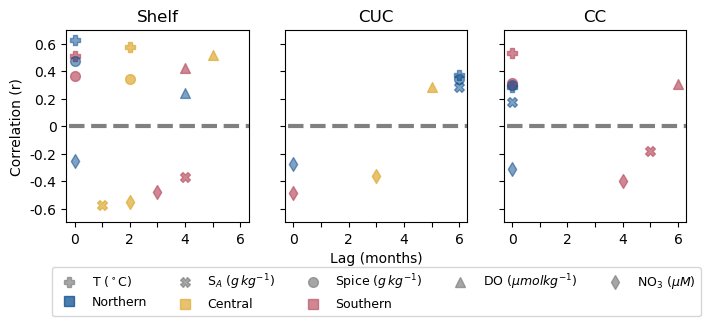

In [20]:
# ENSO
indice= enso

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.7,0.7])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[0], obs_used, indice, dist_edges)

obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[1], obs_used, indice, dist_edges)

obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[2], obs_used, indice, dist_edges)


# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')

<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2871428/305856393.py:36: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2871428/305856393.py:36: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/t

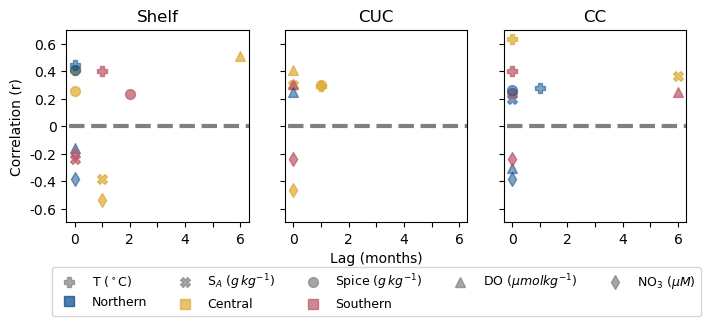

In [21]:
# PDO
indice= pdo

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.7,0.7])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[0], obs_used, indice, dist_edges)

obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[1], obs_used, indice, dist_edges)

obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[2], obs_used, indice, dist_edges)


# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')

<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2871428/111379707.py:36: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2871428/111379707.py:36: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/t

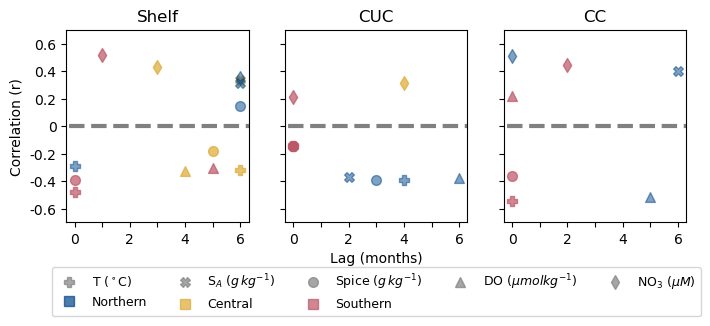

In [22]:
# NPGO
indice= npgo

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.7,0.7])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[0], obs_used, indice, dist_edges)

obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[1], obs_used, indice, dist_edges)

obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[2], obs_used, indice, dist_edges)


# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')

<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2871428/3473755703.py:36: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2871428/3473755703.py:36: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]


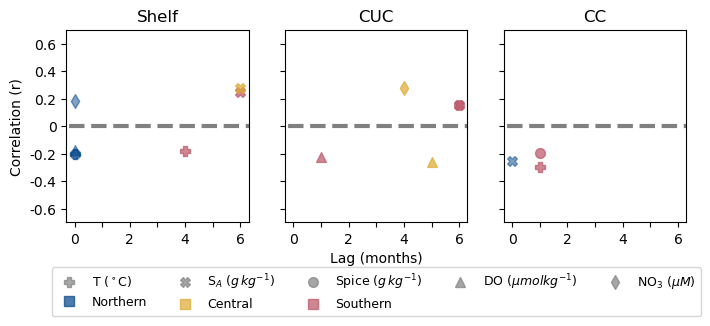

In [23]:
# BI
indice= bi

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.7,0.7])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[0], obs_used, indice, dist_edges)

obs_used = obs_cuc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[1], obs_used, indice, dist_edges)

obs_used = obs_cc.copy()
dist_edges = [np.nanmin(obs_used['latitude (degrees_north)'])-0.1,34.45,40.44,np.nanmax(obs_used['latitude (degrees_north)'])+0.1]
summary_plot(axs[2], obs_used, indice, dist_edges)


# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'Northern', 'S$_A$ ($g \,kg^{-1}$)', 'Central', 'Spice ($g \,kg^{-1}$)','Southern','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','#004488','grey','#DDAA33','grey','#BB5566','grey','grey']
markers = ['P','s','X','s','o','s','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/enso.png', bbox_inches='tight')

<>:85: SyntaxWarning: invalid escape sequence '\c'
<>:85: SyntaxWarning: invalid escape sequence '\,'
<>:85: SyntaxWarning: invalid escape sequence '\,'
<>:85: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\c'
<>:85: SyntaxWarning: invalid escape sequence '\,'
<>:85: SyntaxWarning: invalid escape sequence '\,'
<>:85: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2871428/1972851787.py:85: SyntaxWarning: invalid escape sequence '\c'
  inlegend = ['T ($^\circ$C)', 'North/West', 'S$_A$ ($g \,kg^{-1}$)', 'South', 'Spice ($g \,kg^{-1}$)','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2871428/1972851787.py:85: SyntaxWarning: invalid escape sequence '\,'
  inlegend = ['T ($^\circ$C)', 'North/West', 'S$_A$ ($g \,kg^{-1}$)', 'South', 'Spice ($g \,kg^{-1}$)','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
/tmp/ipykernel_2871428

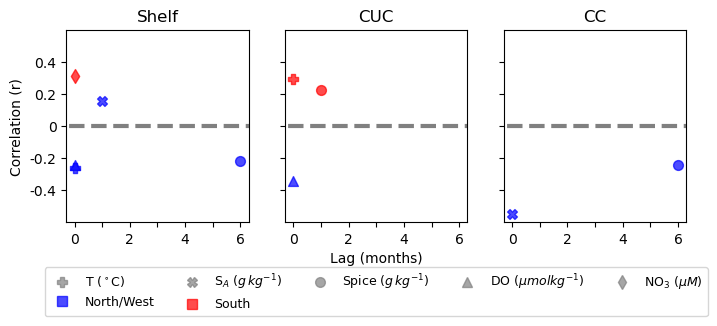

In [ ]:
base_period = (1991, 2020)

num_obs = 50
vars = ['temperature (degC)', 'salinity (g kg-1)','spice','DO (umol kg-1)','NO3 (uM)']
varmark = ['P','X','o','^','d']

dist_edges = [np.min(obs_cc.dist),0,800]

fig, axs = plt.subplots(1,3,figsize=[8,2.5])

for ax in axs:
    ax.set_ylim([-0.6,0.6])
    ax.set_xlim([-0.3,6.3])
    ax.plot([-1,7],[0,0],color='grey',ls='dashed',lw=3)
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
    ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','','2','','4','','6'])
axs[0].set_yticklabels([-0.4,-0.2,0,0.2,0.4])
axs[0].set_ylabel('Correlation (r)')
axs[1].set_xlabel('Lag (months)')
axs[0].set_title('Shelf')
axs[1].set_title('CUC')
axs[2].set_title('CC')

obs_used = obs_shelf.copy()
ax=axs[0]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3,usedist=True
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(add_running_mean_12m(anom_array[1],time), t_month, bi, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='r',alpha=0.7)
    best = _find_best_lag(add_running_mean_12m(anom_array[0],time), t_month, bi, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='b',alpha=0.7)

obs_used = obs_cuc.copy()
ax=axs[1]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3,usedist=True
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(add_running_mean_12m(anom_array[1],time), t_month, bi, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='r',alpha=0.7)
    best = _find_best_lag(add_running_mean_12m(anom_array[0],time), t_month, bi, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='b',alpha=0.7)

obs_used = obs_cc.copy()
ax=axs[2]
for i in range(len(vars)):
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[vars[i]])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[vars[i]])]))

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges,
        vars[i], base_period=base_period, min_samples_per_cell=3,usedist=True
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    best = _find_best_lag(add_running_mean_12m(anom_array[1],time), t_month, bi, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='r',alpha=0.7)
    best = _find_best_lag(add_running_mean_12m(anom_array[0],time), t_month, bi, max_lag_months=6)
    if best['pvalue'] <= 0.01 and best['n'] >num_obs:
        ax.scatter(best['best_lag_months'],best['r'],marker=varmark[i],s=50,c='b',alpha=0.7)

# # build legend handles    
legend_handles = []
inlegend = ['T ($^\circ$C)', 'North/West', 'S$_A$ ($g \,kg^{-1}$)', 'South', 'Spice ($g \,kg^{-1}$)','DO ($\mu mol kg^{-1}$)','NO$_3$ ($\mu M$)',]
colours = ['grey','b','grey','r','grey','grey','grey']
markers = ['P','s','X','s','o','^','d']
for i in range(len(inlegend)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker=markers[i], linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],alpha=0.7,
                          label=inlegend[i]))
# Add a figure-wide legend below the subplots
axs[1].legend(handles=legend_handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.2), frameon=True,fontsize=9)

# plt.savefig('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/output/BI_CCsplit.png', bbox_inches='tight')

## Latitude Anomaly Plots

In [34]:
def showcorrelation(obs_used,variable_str,vmax,base_period=(1991, 2020)):
    
    start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
    end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
    max_dist = np.nanmax(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    min_dist = np.nanmin(obs_used['latitude (degrees_north)'][~np.isnan(obs_used[variable_str])])
    dist_edges1 = [min_dist-0.1,34.45,40.44,max_dist+0.1]
    dist_edges2 = np.arange(min_dist-0.1, max_dist+0.1, 1)

    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges1,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )
    time = decimal_year_monthstart_to_datetime(t_month)

    # ---------- plot ----------
    fig, ax = plt.subplots(5, 1, figsize=(10, 12), constrained_layout=True)

    # --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
    # mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
    indices_name = ['ENSO','PDO','NPGO','BI']
    for i in range(4):
        ax[i].plot(t_month, zscore(add_running_mean_12m(anom_array[2],time), nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
        ax[i].plot(t_month, zscore(add_running_mean_12m(anom_array[1],time), nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
        ax[i].plot(t_month, zscore(add_running_mean_12m(anom_array[0],time), nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
        ax[i].axhline(0, color='k', lw=0.8)
        ax[i].grid(True, alpha=0.3)
        ax[i].set_xlim(start_yr, end_yr + 1)
        ax[i].set_ylabel('NO3 anomaly (uM)')
        ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

        if i ==0:
            Yind = enso['index_rm12']
            Xind = enso['decimal_yr']
            plot_panel(ax[i], add_running_mean_12m(anom_array[2],time), enso,t_month,max_lag_months=6,colour='tab:blue')
            plot_panel(ax[i], add_running_mean_12m(anom_array[1],time), enso,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
            plot_panel(ax[i], add_running_mean_12m(anom_array[0],time), enso,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

        elif i ==1:
            Yind = pdo['index_rm12']
            Xind = pdo['decimal_yr']
            plot_panel(ax[i], add_running_mean_12m(anom_array[2],time), pdo,t_month,max_lag_months=6,colour='tab:blue')
            plot_panel(ax[i], add_running_mean_12m(anom_array[1],time), pdo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
            plot_panel(ax[i], add_running_mean_12m(anom_array[0],time), pdo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

        elif i==2:
            Yind = npgo['index_rm12']
            Xind = npgo['decimal_yr']
            plot_panel(ax[i], add_running_mean_12m(anom_array[2],time), npgo,t_month,max_lag_months=6,colour='tab:blue')
            plot_panel(ax[i], add_running_mean_12m(anom_array[1],time), npgo,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
            plot_panel(ax[i], add_running_mean_12m(anom_array[0],time), npgo,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

        elif i==3:
            Yind = bi['index_rm12']
            Xind = bi['decimal_yr']
            plot_panel(ax[i], add_running_mean_12m(anom_array[2],time), bi,t_month,max_lag_months=6,colour='tab:blue')
            plot_panel(ax[i], add_running_mean_12m(anom_array[1],time), bi,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)
            plot_panel(ax[i], add_running_mean_12m(anom_array[0],time), bi,t_month,max_lag_months=6,colour='tab:red',xloc=0,yloc=0.2)

        ax[i].plot(Xind, Yind, color='gray', lw=1)
    ax[0].legend(loc = 'upper right')

    # --- bottom panel: depth–time contour ---
    anom_array, t_month = contour_prep_dist_monthly(
        obs_used, start_yr, end_yr, dist_edges2,
        variable_str, base_period=base_period, min_samples_per_cell=3
    )

    X, Y = np.meshgrid(t_month, dist_edges2[:-1])
    vmax = vmax
    levels = np.linspace(-vmax, vmax, 80)
    cp = ax[4].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
    ax[4].set_xlim(start_yr, end_yr + 1)
    ax[4].set_xlabel('Year')
    ax[4].set_ylabel('Latitude ($^\circ$N)')
    ax[4].plot([start_yr, end_yr + 1],[34.45,34.45],'k--',alpha=0.5)
    ax[4].plot([start_yr, end_yr + 1],[40.44,40.44],'k--',alpha=0.5)
    ax[4].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

    cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                        aspect=40, shrink=0.75, ticks=[-vmax, 0,vmax])
    cbar.set_label(f"{variable_str} anomaly")


<>:75: SyntaxWarning: invalid escape sequence '\c'
<>:75: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2748040/967383605.py:75: SyntaxWarning: invalid escape sequence '\c'
  ax[4].set_ylabel('Latitude ($^\circ$N)')


### Temperature

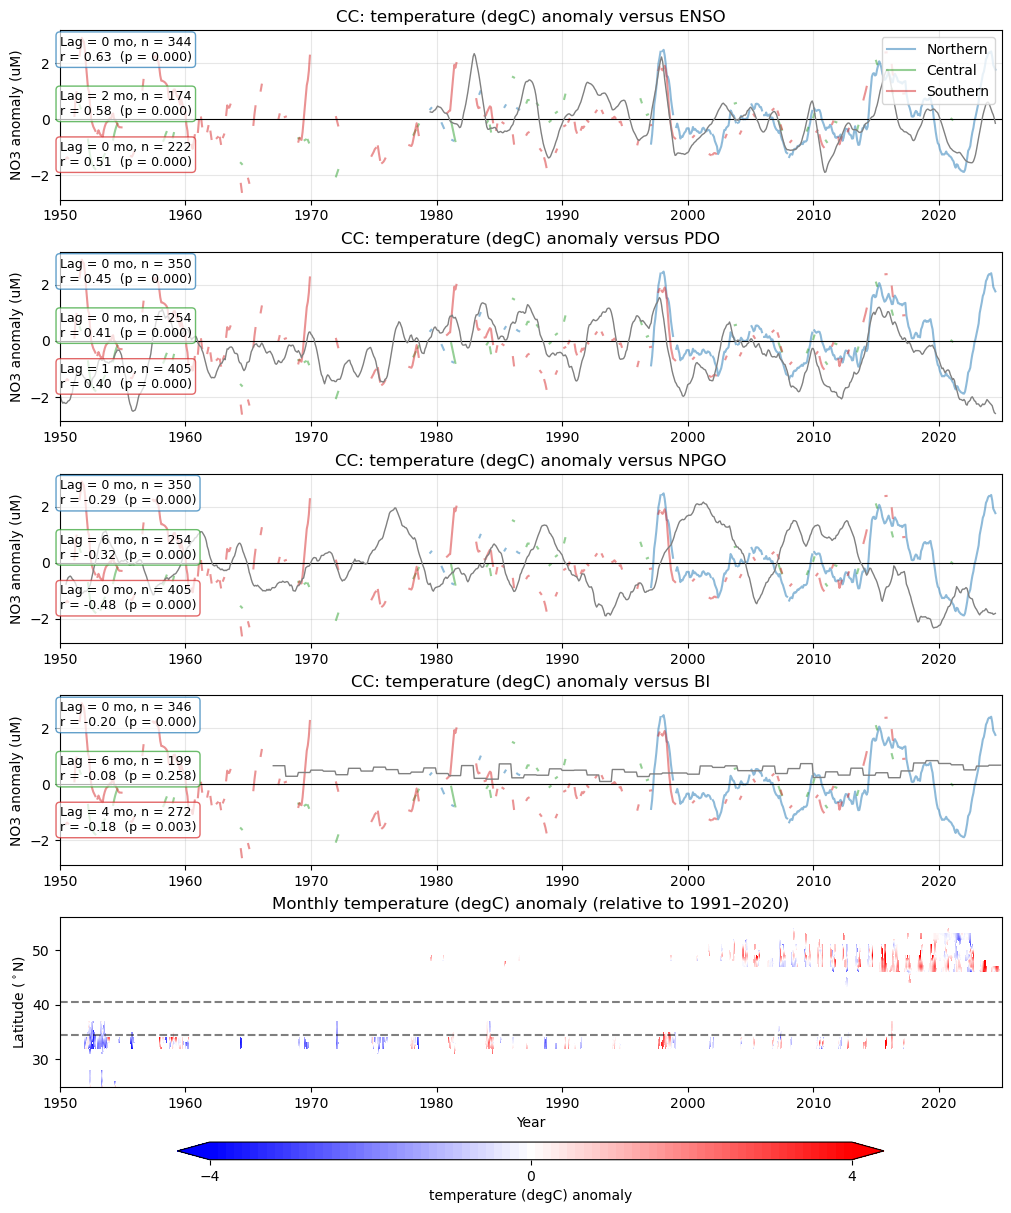

In [35]:
obs_used = obs_shelf.copy()
variable_str = 'temperature (degC)'
showcorrelation(obs_used,variable_str,vmax=4)

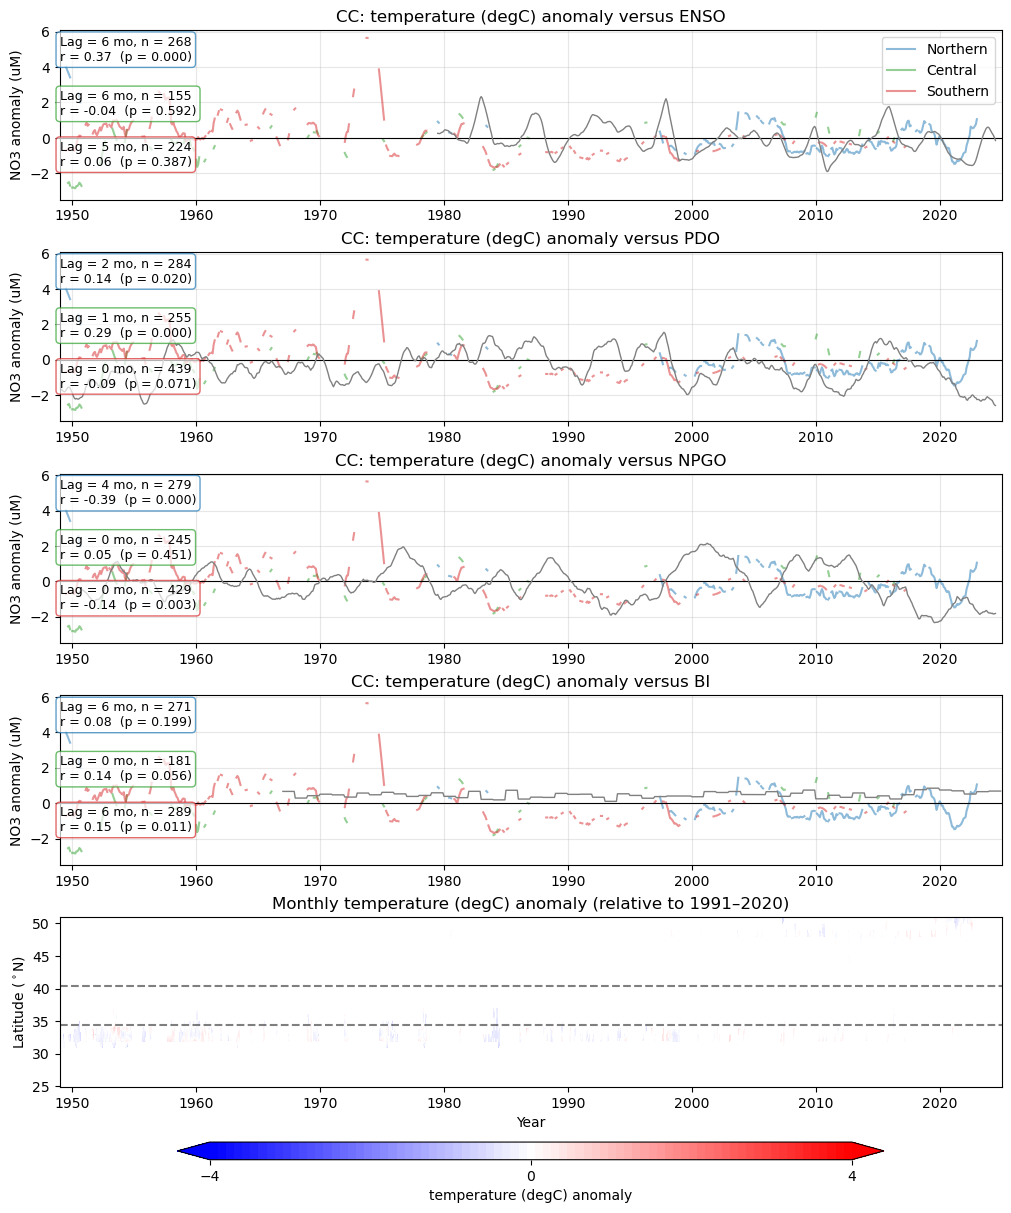

In [36]:
obs_used = obs_cuc.copy()
variable_str = 'temperature (degC)'
showcorrelation(obs_used,variable_str,vmax=4)

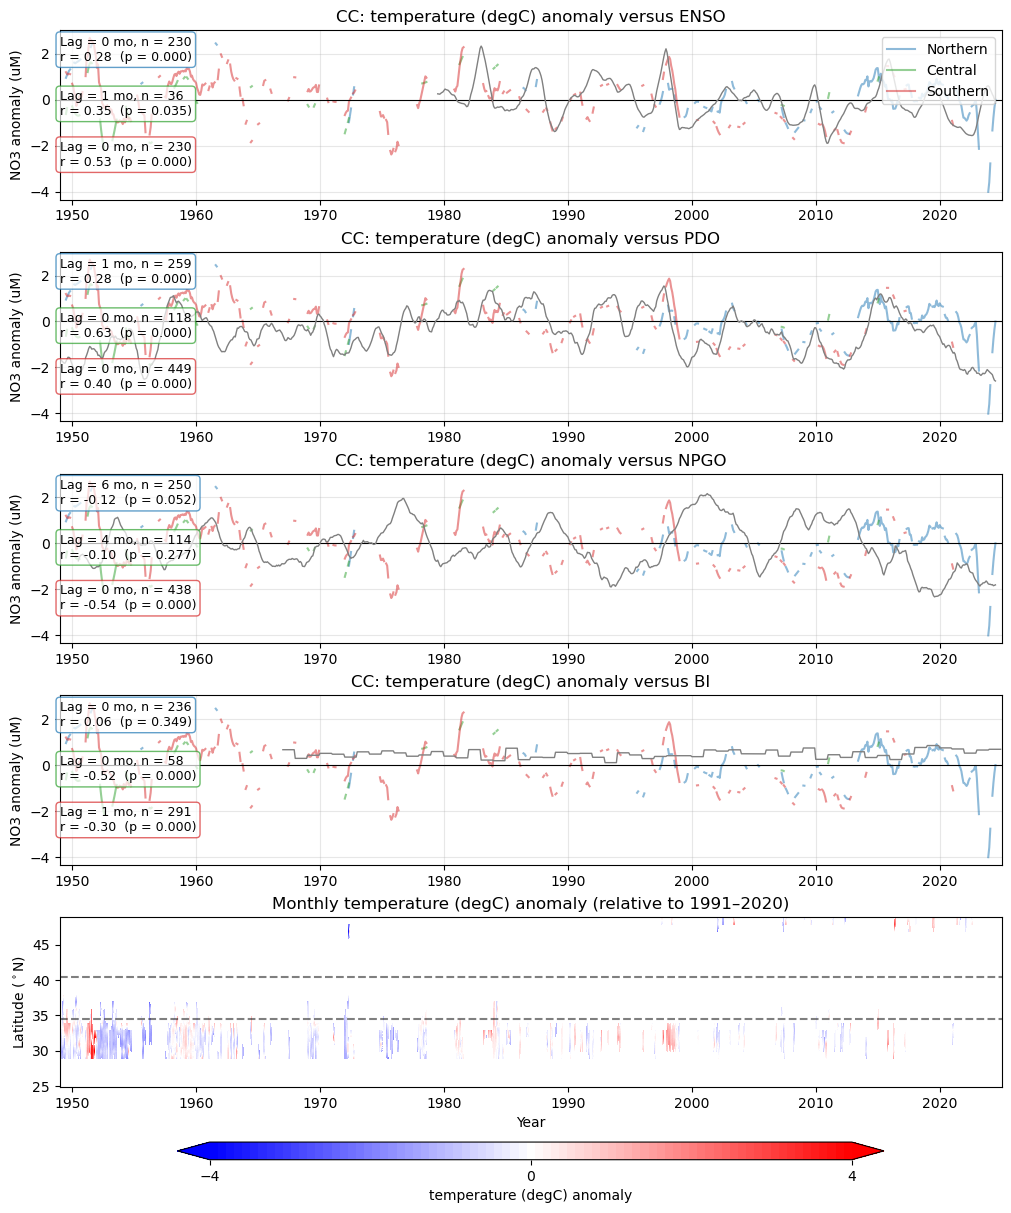

In [37]:
obs_used = obs_cc.copy()
variable_str = 'temperature (degC)'
showcorrelation(obs_used,variable_str,vmax=4)

### Salinity

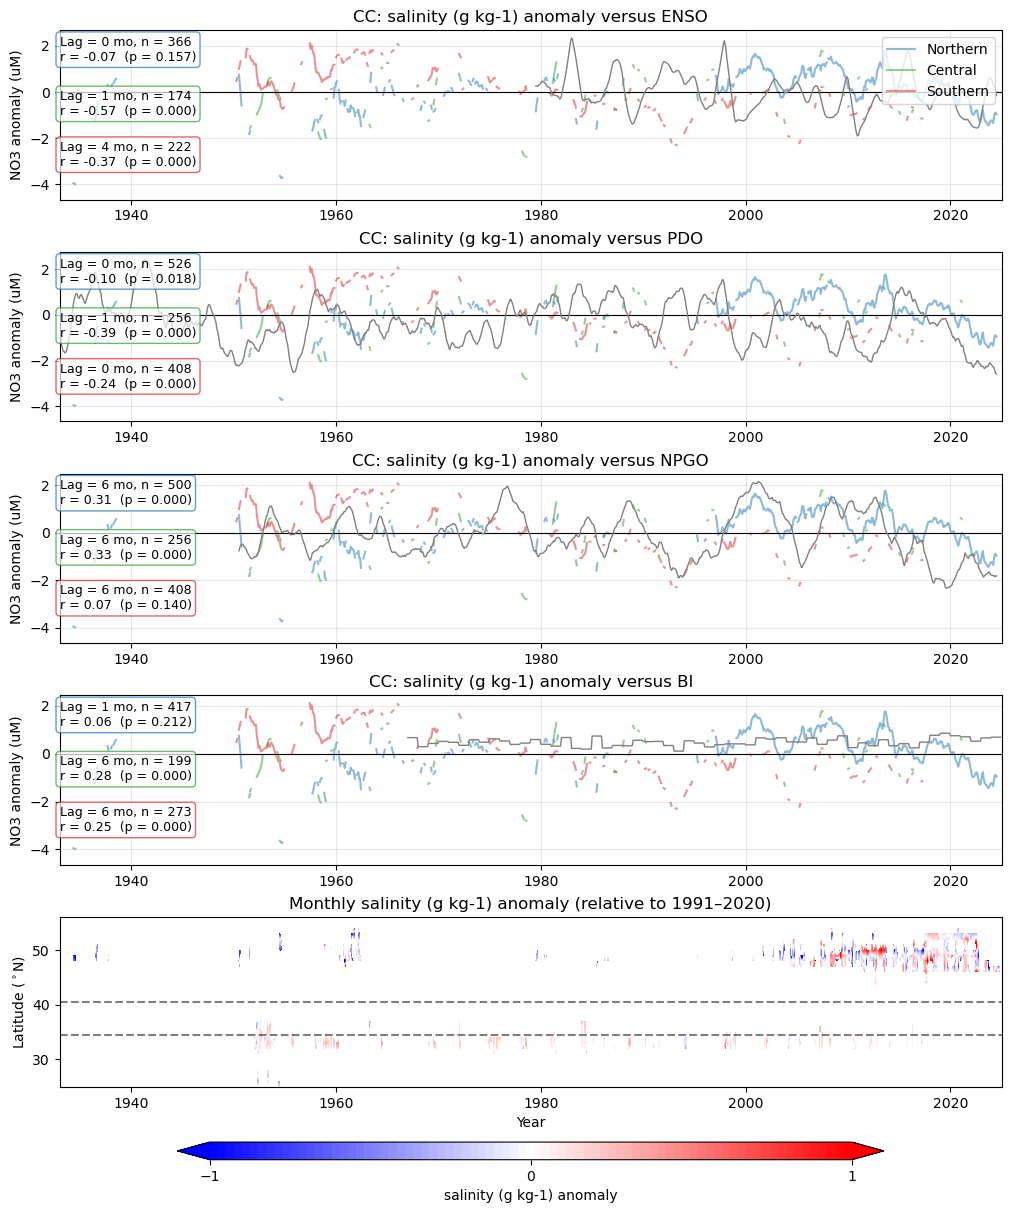

In [38]:
obs_used = obs_shelf.copy()
variable_str = 'salinity (g kg-1)'
showcorrelation(obs_used,variable_str,vmax=1)

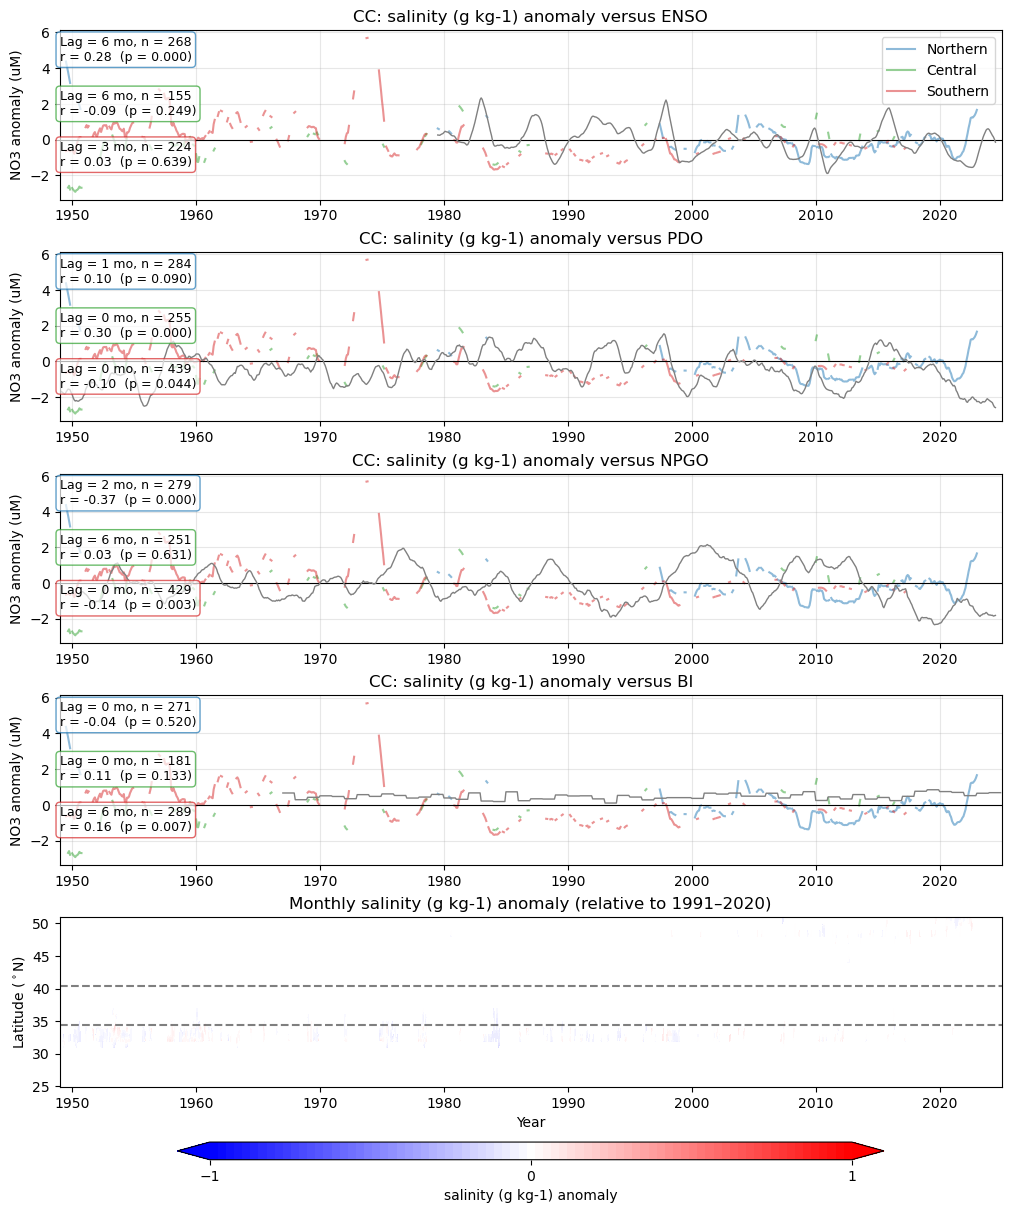

In [39]:
obs_used = obs_cuc.copy()
variable_str = 'salinity (g kg-1)'
showcorrelation(obs_used,variable_str,vmax=1)


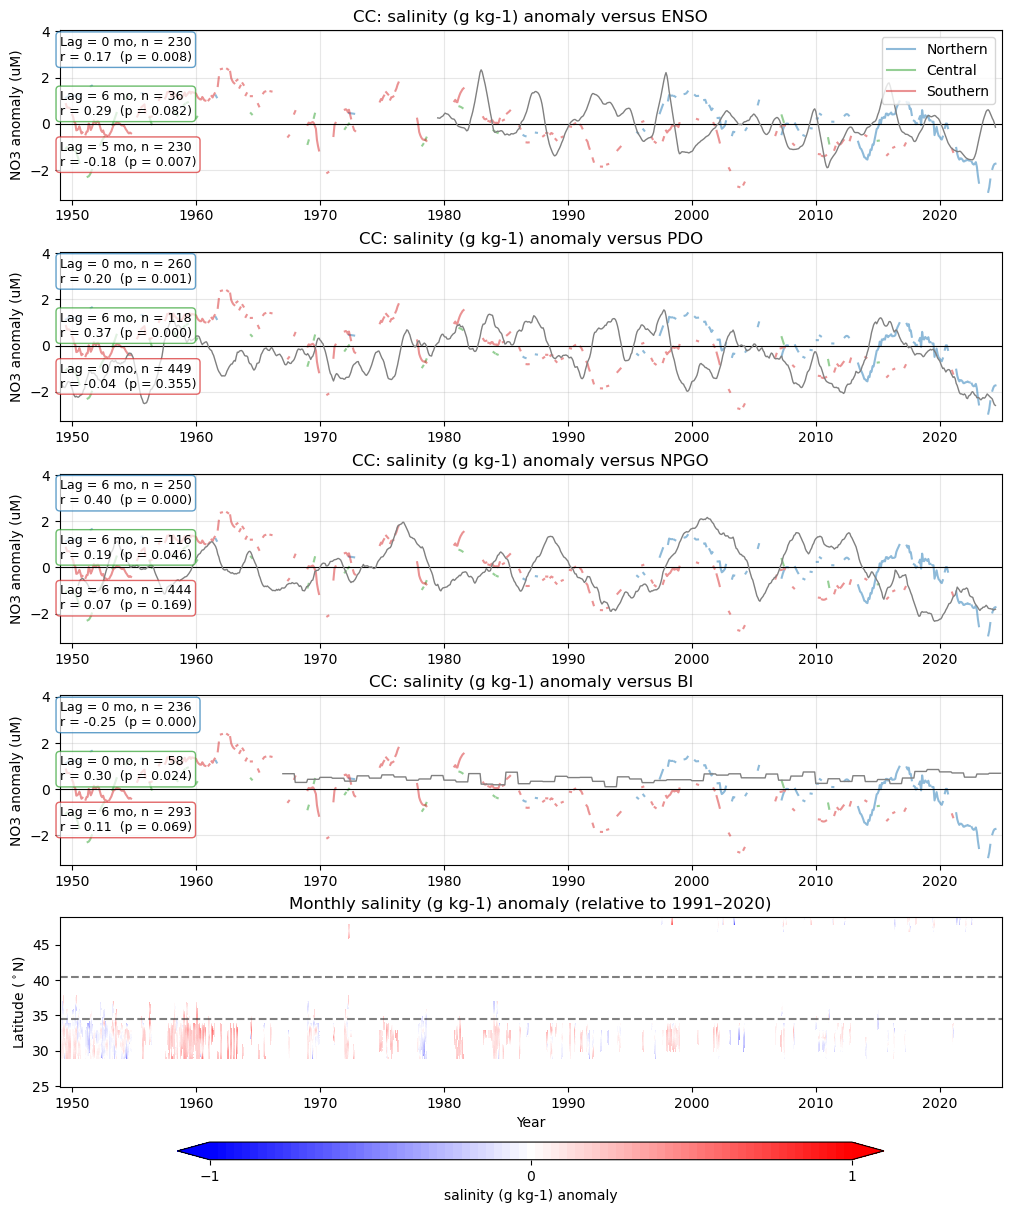

In [40]:
obs_used = obs_cc.copy()
variable_str = 'salinity (g kg-1)'
showcorrelation(obs_used,variable_str,vmax=1)

### DO

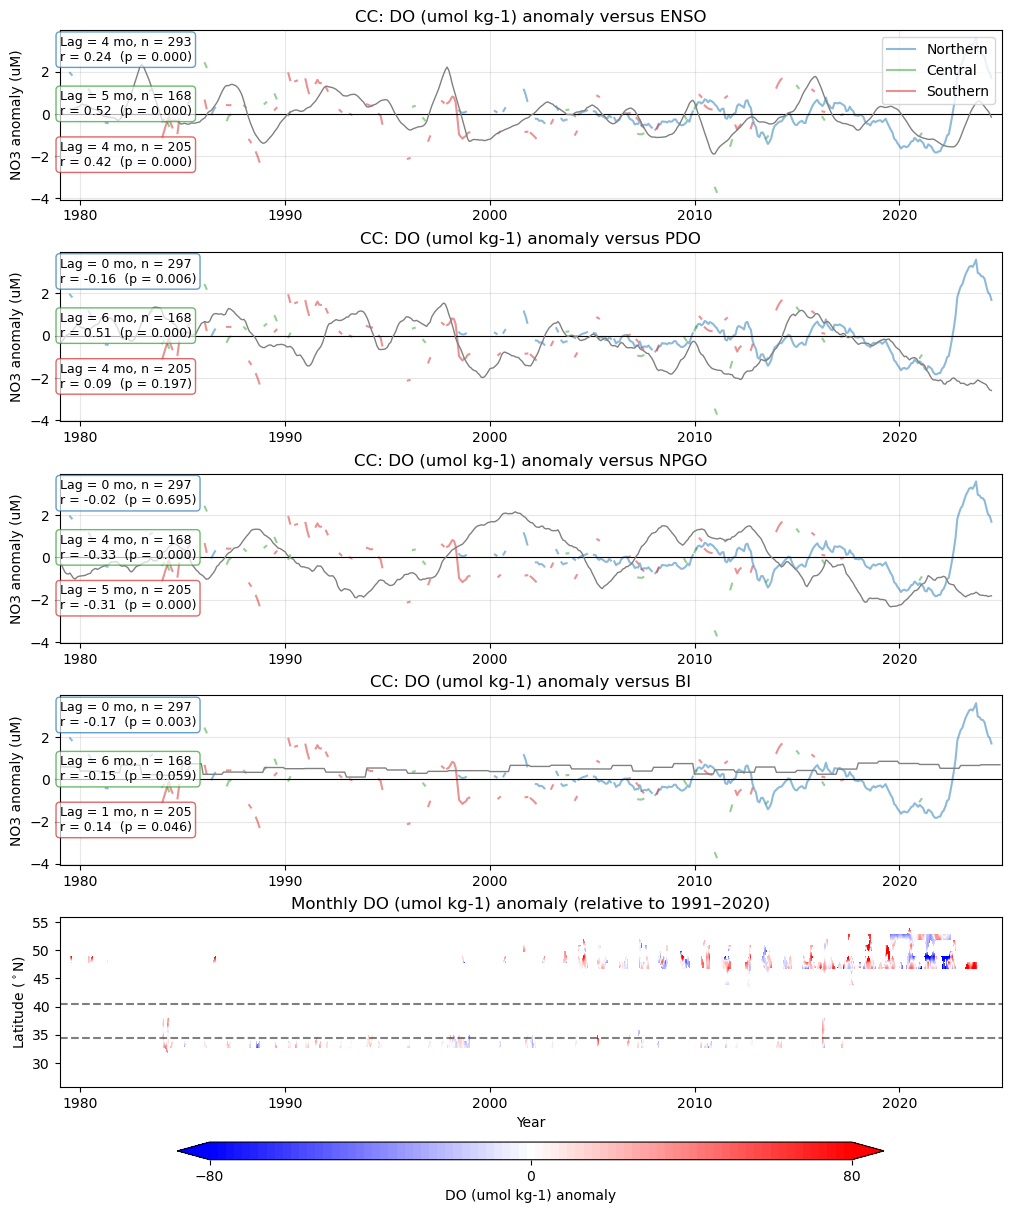

In [41]:
obs_used = obs_shelf.copy()
variable_str = 'DO (umol kg-1)'
showcorrelation(obs_used,variable_str,vmax=80)

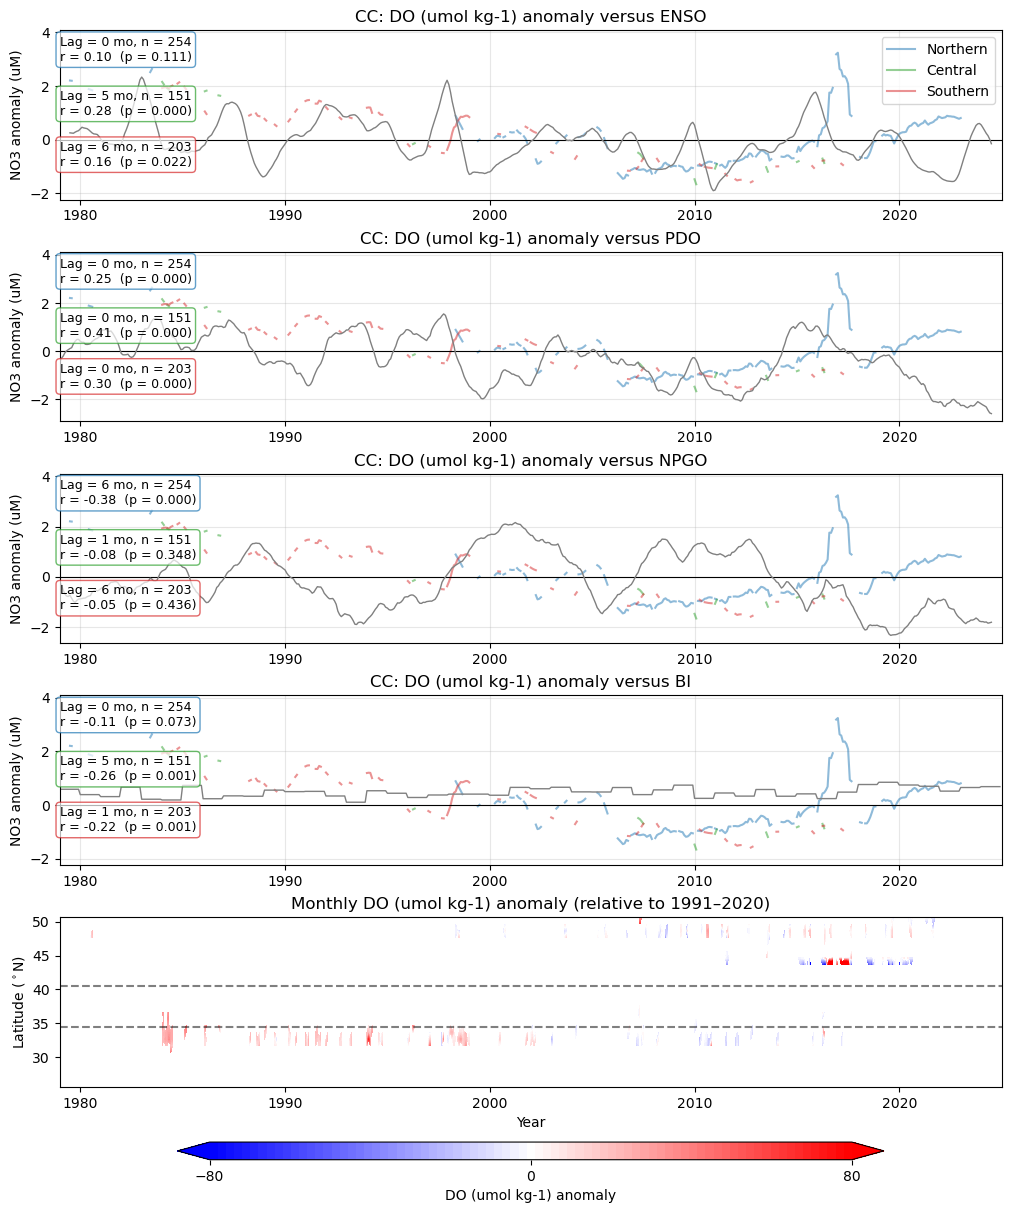

In [42]:
obs_used = obs_cuc.copy()
variable_str = 'DO (umol kg-1)'
showcorrelation(obs_used,variable_str,vmax=80)

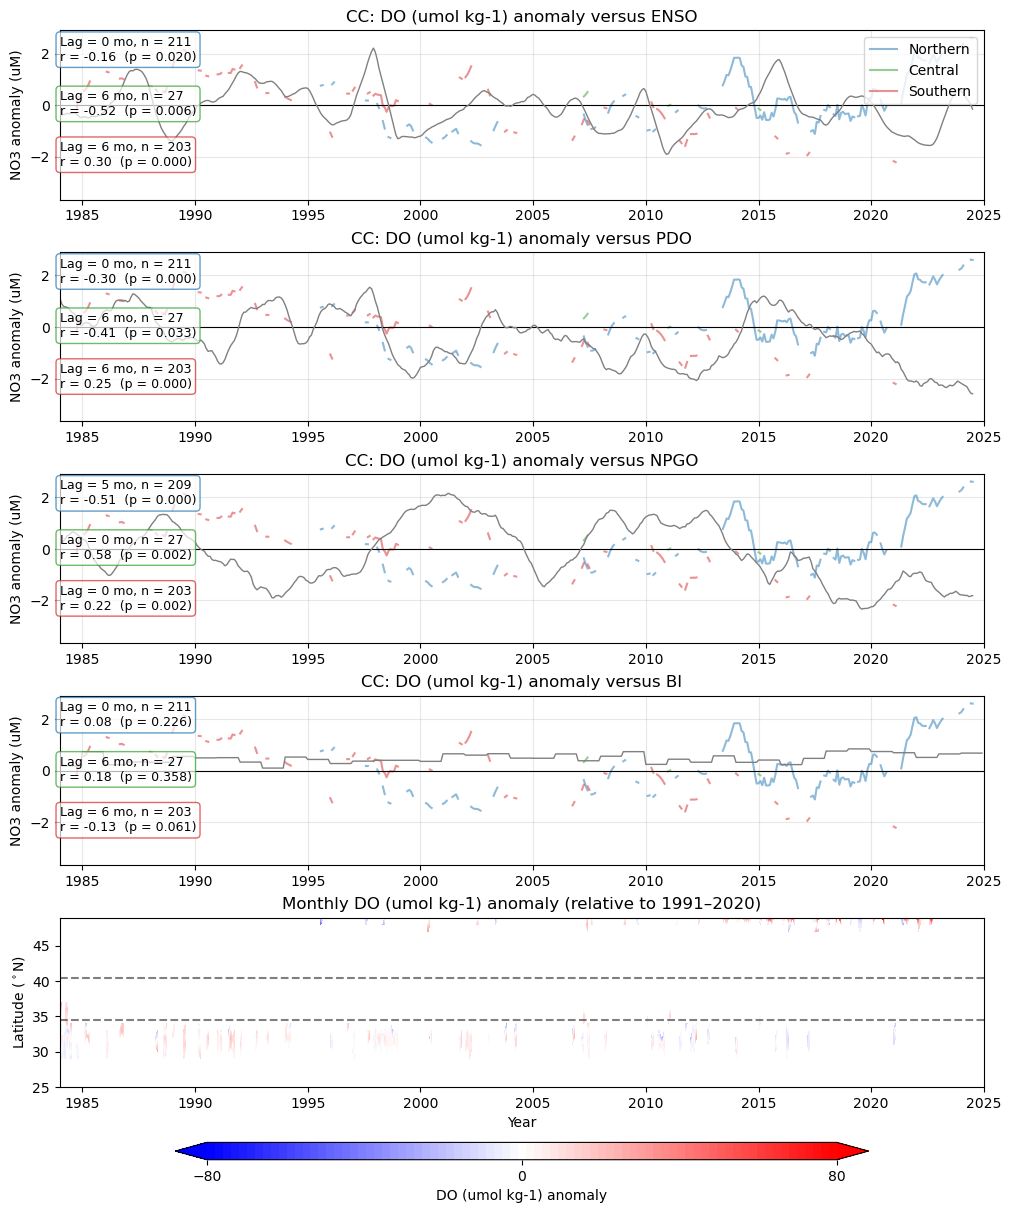

In [43]:
obs_used = obs_cc.copy()
variable_str = 'DO (umol kg-1)'
showcorrelation(obs_used,variable_str,vmax=80)

### NO3

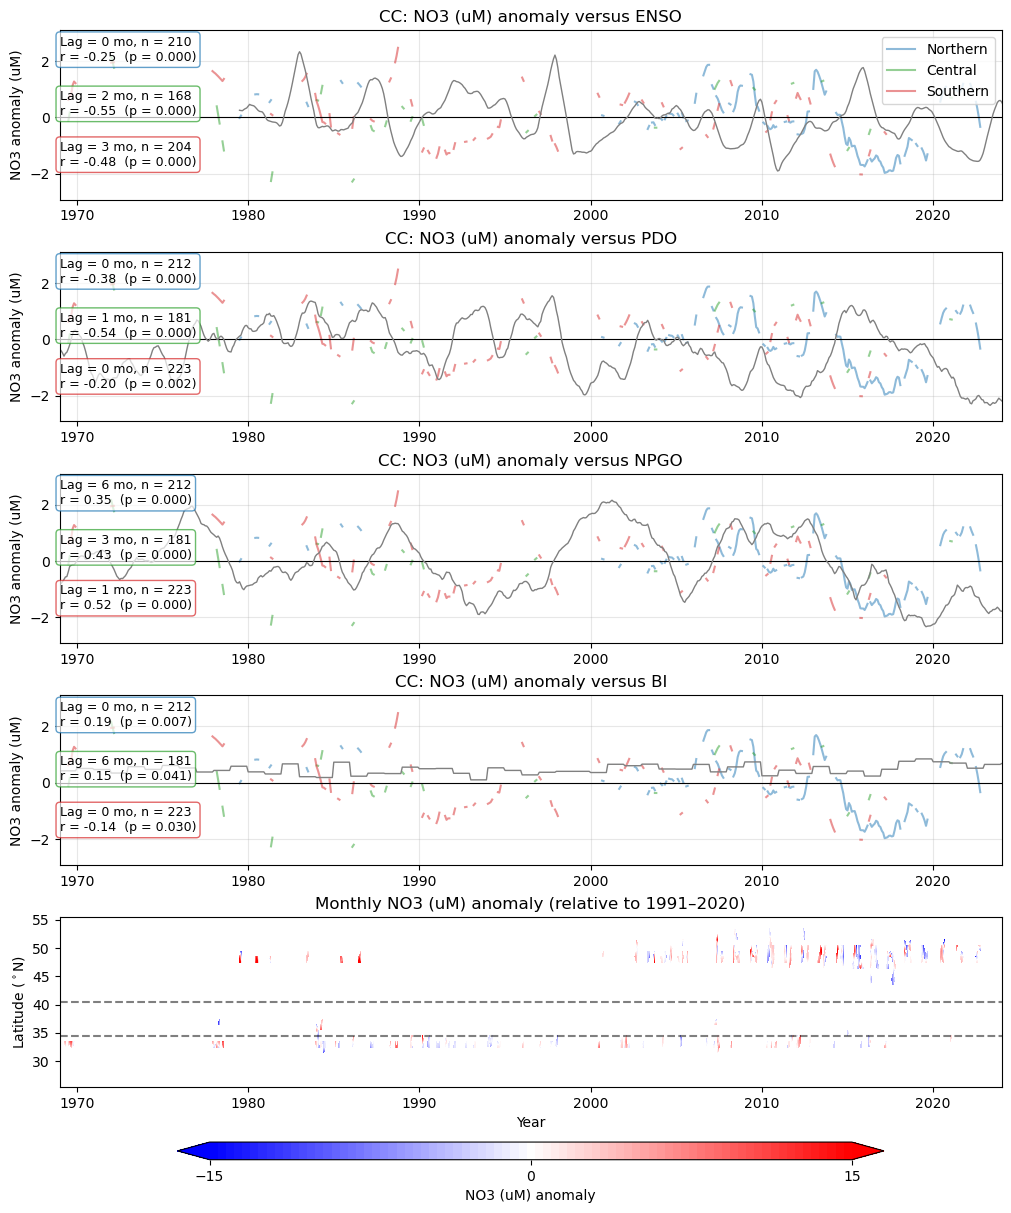

In [44]:
obs_used = obs_shelf.copy()
variable_str = 'NO3 (uM)'
showcorrelation(obs_used,variable_str,vmax=15)

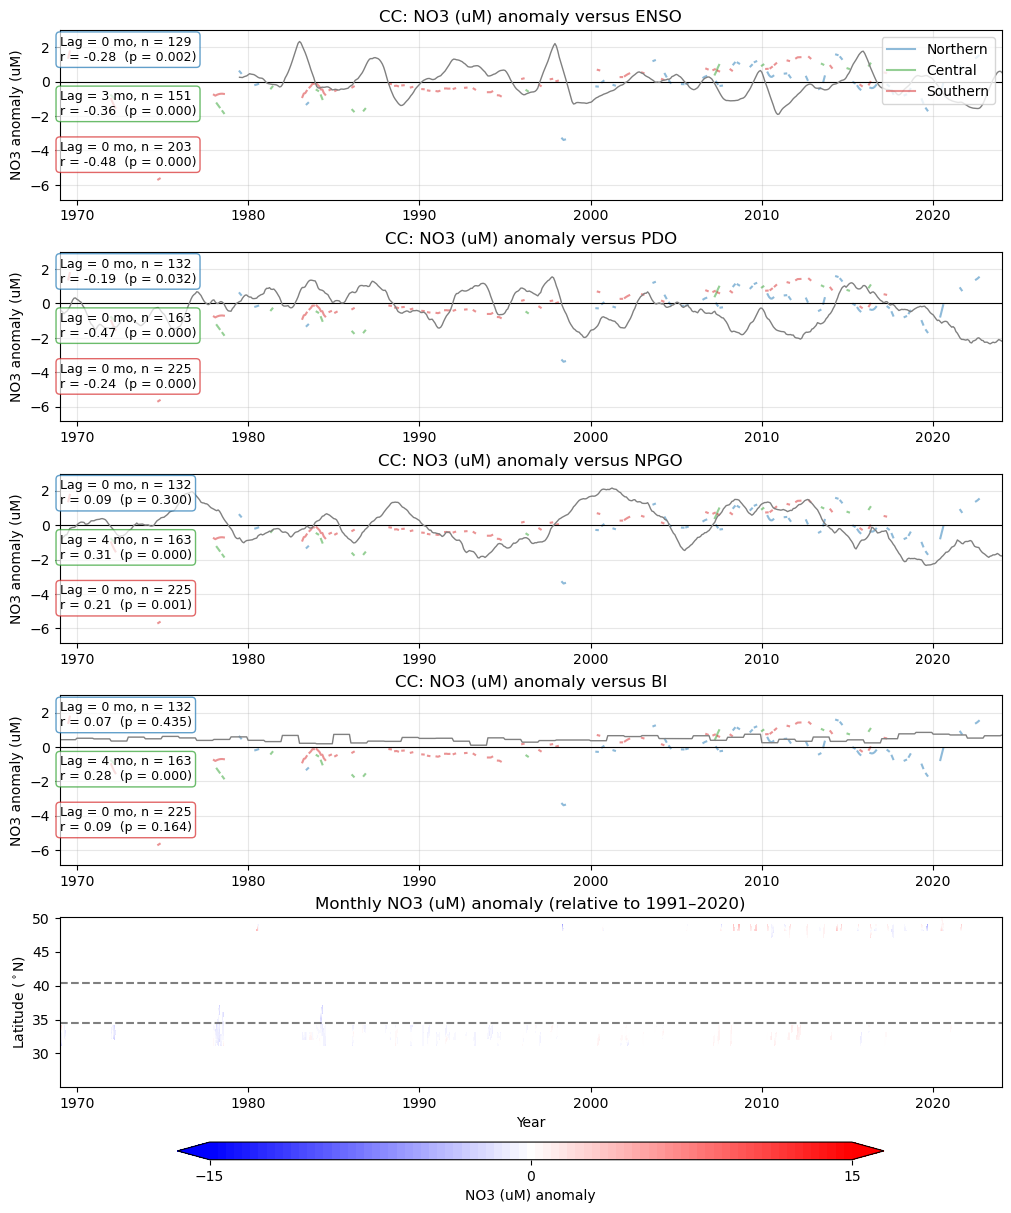

In [45]:
obs_used = obs_cuc.copy()
variable_str = 'NO3 (uM)'
showcorrelation(obs_used,variable_str,vmax=15)

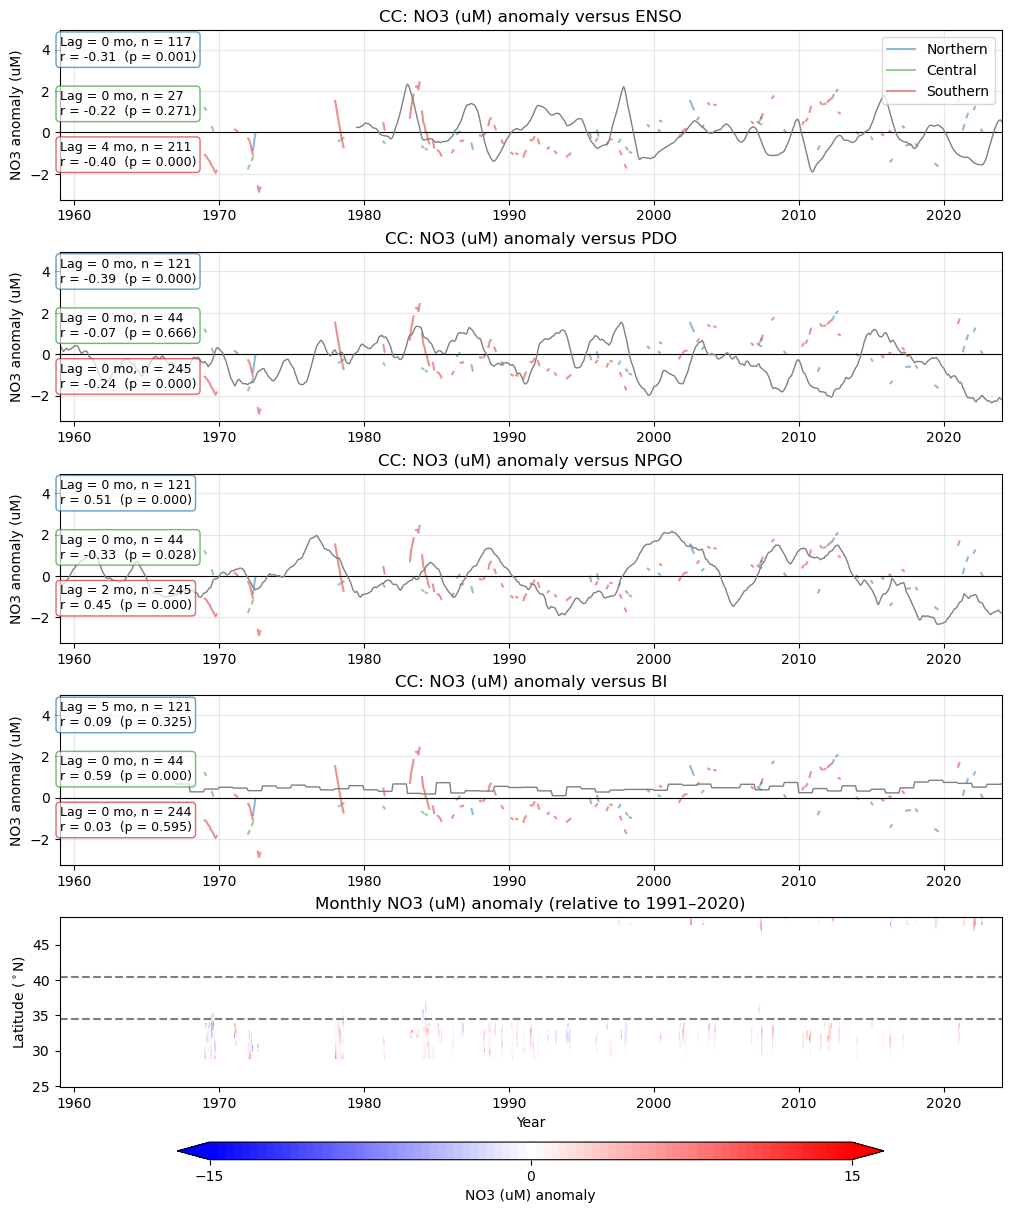

In [46]:
obs_used = obs_cc.copy()
variable_str = 'NO3 (uM)'
showcorrelation(obs_used,variable_str,vmax=15)

## CC split

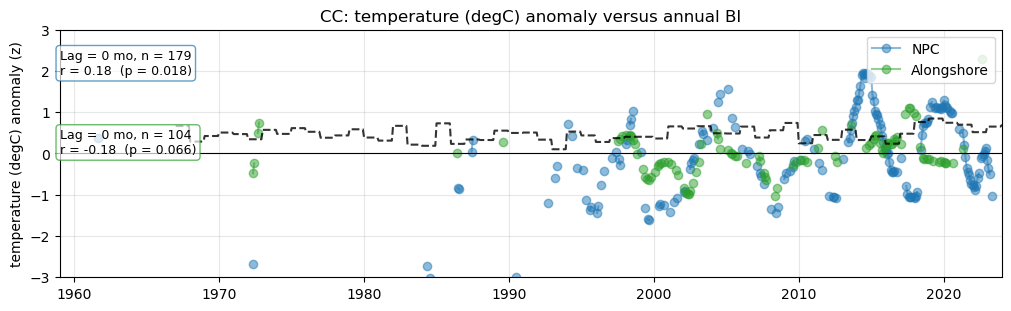

In [50]:
obs_used = obs_cc.copy()
variable_str = 'temperature (degC)'

dist_edges = [np.min(obs_cc.dist),0,700]

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3,usedist=True
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)

ax.plot(t_month, zscore(add_running_mean_12m(anom_array[0],time), nan_policy='omit'), color='tab:blue',marker='o', lw=1.5,alpha=0.5, label='NPC') # zscore converts the anom to a -1-1 variation based on std above and below mean
ax.plot(t_month, zscore(add_running_mean_12m(anom_array[1],time), nan_policy='omit'), color='tab:green',marker='o', lw=1.5,alpha=0.5, label='Alongshore')

ax.plot(bi.decimal_yr,bi['index_rm12'],'k--',alpha=0.8)

plot_panel(ax, add_running_mean_12m(anom_array[0],time), bi,t_month,max_lag_months=6,colour='tab:blue')
plot_panel(ax, add_running_mean_12m(anom_array[1],time), bi,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)


ax.axhline(0, color='k', lw=0.8)
ax.grid(True, alpha=0.3)
ax.set_xlim(start_yr, end_yr + 1)
ax.set_ylim(-3,3)
ax.set_ylabel(f'{variable_str} anomaly (z)')
ax.set_title(f"CC: {variable_str} anomaly versus annual BI")

ax.legend(loc='upper right')

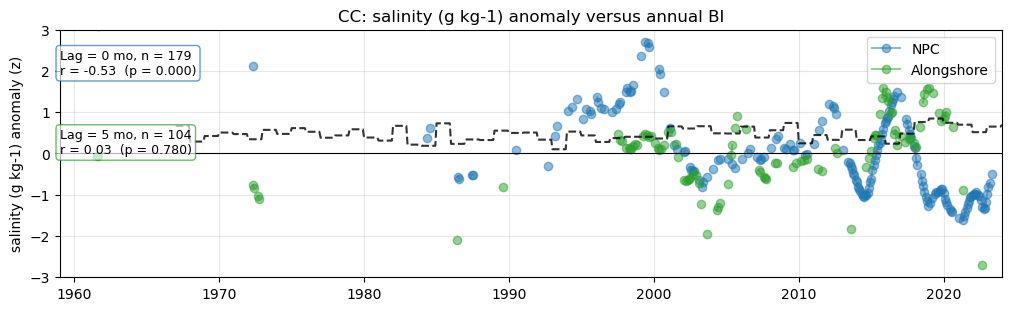

In [51]:
obs_used = obs_cc.copy()
variable_str = 'salinity (g kg-1)'

dist_edges = [np.min(obs_cc.dist),0,700]

base_period = (1991, 2020)

# monthly anomalies needed for month-lagging
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3,usedist=True
)
time = decimal_year_monthstart_to_datetime(t_month)

# ---------- plot ----------
fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)

ax.plot(t_month, zscore(add_running_mean_12m(anom_array[0],time), nan_policy='omit'), color='tab:blue',marker='o', lw=1.5,alpha=0.5, label='NPC') # zscore converts the anom to a -1-1 variation based on std above and below mean
ax.plot(t_month, zscore(add_running_mean_12m(anom_array[1],time), nan_policy='omit'), color='tab:green',marker='o', lw=1.5,alpha=0.5, label='Alongshore')

ax.plot(bi.decimal_yr,bi['index_rm12'],'k--',alpha=0.8)

plot_panel(ax, add_running_mean_12m(anom_array[0],time), bi,t_month,max_lag_months=6,colour='tab:blue')
plot_panel(ax, add_running_mean_12m(anom_array[1],time), bi,t_month,max_lag_months=6,colour='tab:green',xloc=0,yloc=0.5)


ax.axhline(0, color='k', lw=0.8)
ax.grid(True, alpha=0.3)
ax.set_xlim(start_yr, end_yr + 1)
ax.set_ylim(-3,3)
ax.set_ylabel(f'{variable_str} anomaly (z)')
ax.set_title(f"CC: {variable_str} anomaly versus annual BI")

ax.legend(loc='upper right')